I. Set Up

In [1]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
import statistics
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
# CIAO Imports
# import ciao_contrib.runtool
# from ciao_contrib.runtool import *
# CUSTOM Imports
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

ModuleNotFoundError: No module named 'data_exploration_functions'

II. Number of Bins

In [2]:
# Set ID
set_id = set_widget.value
# Reduce data for useful input to data representation
# df_eventfiles = pd.read_csv(f'{global_path}/{set_id}/eventfiles-{set_id}.csv')
# df_properties = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
# df_eventfiles_input, df_properties_input = data_reduction_fun(df_eventfiles, df_properties,global_path,set_id,min_counts = 40)
# Load Input
df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
# Group Data
df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')
# Filter for Minimum 40 events
#df_eventfiles_group = df_eventfiles_group.filter(lambda x: len(x) > 49).groupby('obsreg_id')
#keep_obsreg = list(df_eventfiles_group.groups.keys())
#df_properties_group = df_properties_group.filter(lambda x: x.name in keep_obsreg).groupby('obsreg_id')

# Print info
print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
print("Number of Property Sets: ", df_properties_group.ngroups)


Number of Eventfiles:  82283
Number of Property Sets:  82283


Run

In [3]:
nbin_E_list = []
nbin_dt_list = []
nbin_t_list = []

sturges_list = []

scotts_E_list = []
scotts_dt_list = []
scotts_t_list = []

T_list = []
N_list = []
scaled_delta_time_min_list = []
no_scaled_delta_time_min_list = []

count = 0
fails = 0
count_limit = df_eventfiles_group.ngroups
id_fail = []
id_pass = []

for id_name, dfi in df_eventfiles_group:
    # Get the dataframe for the current group
    dfi["delta_time"] = dfi['time'].diff()
    dfi = dfi[dfi["delta_time"].notna()]
    # Add a constant value to delta_time = 0
    dfi["delta_time"] = dfi["delta_time"].apply(lambda dt: np.where(dt == 0, dt + 0.01, dt))
    try:
        # Number and Total Duration of Events
        N = len(dfi)
        T = max(dfi["time"])-min(dfi["time"])
        E = max(dfi["energy"])-min(dfi["energy"])
        scaled_delta_time =  N * min(dfi["delta_time"])/T
        no_scaled_delta_time =  min(dfi["delta_time"])
        # Add dt column (with normalisations applied)
        dfi["dt"] = np.log(100 * N * dfi["delta_time"]/T)
        #dfi["dt"] = N/T * dfi["delta_time"]
        #dfi["dt"] = (N/T * dfi["delta_time"]) ** 2
        # dfi["dt"] = np.exp(N * dfi["delta_time"]/T)
        #dfi["dt"] = np.log2(100 * dfi["delta_time"])
        dt_min = min(dfi["dt"])
        dt_max = max(dfi["dt"])
        dfi["dt"] = (dfi["dt"]- dt_min)/(dt_max-dt_min)
        # Add t column
        dfi["t"] = N*(dfi["time"]-min(dfi["time"]))/T
        t_min = min(dfi["t"])
        t_max = max(dfi["t"])
        dfi["t"] = (dfi["t"]- t_min)/(t_max-t_min)
        # Add E column
        dfi["E"] = np.log(dfi["energy"])
        # Freedman-Diaconis rule ENERGY
        iqr_E = np.subtract(*np.percentile(dfi['E'], [75, 25], axis=0)) #IQ range
        binwidth_E = 2 * iqr_E / (len(dfi['E']) ** (1/3))
        nbins_E = int(np.ceil((dfi['E'].max() - dfi['E'].min()) / binwidth_E))
        # Freedman-Diaconis rule DT
        iqr_dt = np.subtract(*np.percentile(dfi['dt'], [75, 25], axis=0)) #IQ range
        binwidth_dt = 2 * iqr_dt / (len(dfi['dt']) ** (1/3))
        nbins_dt = int(np.ceil((dfi['dt'].max() - dfi['dt'].min()) / binwidth_dt))
        # Freedman-Diaconis rule T
        iqr_t = np.subtract(*np.percentile(dfi['t'], [75, 25], axis=0)) #IQ range
        binwidth_t = 2 * iqr_t / (len(dfi['t']) ** (1/3))
        nbins_t = int(np.ceil((dfi['t'].max() - dfi['t'].min()) / binwidth_t))
        # Sturges Rule
        k = int(np.ceil(1 + np.log2(N)))
        # Scotts Rule
        w_E = 3.5 * np.std(dfi['E']) / (N ** (1/3))
        w_dt = 3.5 * np.std(dfi['dt']) / (N ** (1/3))
        w_t = 3.5 * np.std(dfi['t']) / (N ** (1/3))
        k_E = int(np.ceil((dfi['E'].max() - dfi['E'].min()) / w_E))
        k_dt = int(np.ceil((dfi['dt'].max() - dfi['dt'].min()) / w_dt))
        k_t = int(np.ceil((dfi['t'].max() - dfi['t'].min()) / w_t))

        # Append optimal bins lists
        nbin_E_list.append(nbins_E)
        nbin_dt_list.append(nbins_dt)
        nbin_t_list.append(nbins_t)
        sturges_list.append(k)
        scotts_E_list.append(k_E)
        scotts_dt_list.append(k_dt)
        scotts_t_list.append(k_t)
        T_list.append(T)
        N_list.append(N)
        scaled_delta_time_min_list.append(scaled_delta_time)
        no_scaled_delta_time_min_list.append(no_scaled_delta_time)

        count = count + 1
        print(f'Counter: {count} / {count_limit}')
        clear_output(wait=True)
        id_pass.append(id_name)
    except:
        fails = fails + 1
        print(f'Fails: {fails}')
        id_fail.append(id_name)
        clear_output(wait=True)

Fails: 1293


/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyboardInterrupt: 

Save

In [7]:
# Set ID
set_id = set_widget.value
# Describe 
describe = 'loloN50'
# Save FD
with open(f'{global_path}/{set_id}/nbin_E_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_E_list, file)
with open(f'{global_path}/{set_id}/nbin_dt_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_dt_list, file)
with open(f'{global_path}/{set_id}/nbin_t_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_t_list, file)
# Save Sturges
with open(f'{global_path}/{set_id}/n_sturges-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(sturges_list, file)
# Save Scott
with open(f'{global_path}/{set_id}/nbin_E_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_E_list, file)
with open(f'{global_path}/{set_id}/nbin_dt_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_dt_list, file)
with open(f'{global_path}/{set_id}/nbin_t_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_t_list, file)

# Save T
with open(f'{global_path}/{set_id}/Tlist-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(T_list, file)
# Save N
with open(f'{global_path}/{set_id}/Nlist-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(N_list, file)
# Save min scaled delta_time
with open(f'{global_path}/{set_id}/scaled_dt_list-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scaled_delta_time_min_list, file)
# Save min delta_time
with open(f'{global_path}/{set_id}/no_scaled_dt_list-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(no_scaled_delta_time_min_list, file)

# Save IDs
with open(f'{global_path}/{set_id}/idpass-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(id_pass, file)
with open(f'{global_path}/{set_id}/idfail-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(id_fail, file)

Load

In [8]:
# Set ID
set_id = set_widget.value
# Describe 
describe = 'loloN50'
with open(f'{global_path}/{set_id}/nbin_E_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_E_list = pickle.load(file)
with open(f'{global_path}/{set_id}/nbin_dt_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_dt_list = pickle.load(file)
with open(f'{global_path}/{set_id}/nbin_t_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_t_list = pickle.load(file)
# Open Sturges
with open(f'{global_path}/{set_id}/n_sturges-{set_id}-{describe}.pickle', "rb") as file:
    sturges_list = pickle.load(file)
# Open Scott
with open(f'{global_path}/{set_id}/nbin_E_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_E_list = pickle.load(file)
with open(f'{global_path}/{set_id}/nbin_dt_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_dt_list = pickle.load(file)
with open(f'{global_path}/{set_id}/nbin_t_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_t_list = pickle.load(file)

# Open T
with open(f'{global_path}/{set_id}/Tlist-{set_id}-{describe}.pickle', "rb") as file:
    T_list = pickle.load(file)
# Open N
with open(f'{global_path}/{set_id}/Nlist-{set_id}-{describe}.pickle', "rb") as file:
    N_list = pickle.load(file)
# Open min scaled dt
with open(f'{global_path}/{set_id}/scaled_dt_list-{set_id}-{describe}.pickle', "rb") as file:
    scaled_dt_list = pickle.load(file)
with open(f'{global_path}/{set_id}/no_scaled_dt_list-{set_id}-{describe}.pickle', "rb") as file:
    no_scaled_dt_list = pickle.load(file)

# Open IDs
with open(f'{global_path}/{set_id}/idpass-{set_id}-{describe}.pickle', "rb") as file:
    id_pass = pickle.load(file)
with open(f'{global_path}/{set_id}/idfail-{set_id}-{describe}.pickle', "rb") as file:
    id_fail = pickle.load(file)

In [16]:
print(nbin_dt_list)

[18, 8, 10, 11, 11, 20, 18, 21, 13, 7, 9, 6, 25, 14, 12, 13, 6, 27, 7, 12, 6, 11, 6, 18, 25, 9, 6, 7, 8, 10, 8, 9, 9, 13, 24, 9, 9, 9, 9, 6, 10, 18, 13, 9, 7, 10, 12, 8, 13, 8, 11, 9, 24, 28, 9, 7, 10, 27, 14, 14, 29, 27, 13, 8, 7, 8, 24, 20, 9, 7, 13, 12, 6, 11, 36, 9, 7, 7, 7, 9, 6, 9, 8, 28, 21, 21, 9, 8, 9, 22, 9, 17, 30, 12, 9, 15, 5, 22, 8, 21, 7, 9, 6, 6, 17, 18, 10, 29, 9, 25, 6, 12, 33, 11, 11, 23, 12, 23, 12, 5, 6, 8, 10, 5, 18, 7, 6, 10, 9, 9, 7, 9, 9, 13, 10, 8, 23, 8, 22, 9, 7, 8, 8, 31, 6, 21, 24, 24, 19, 19, 8, 10, 6, 8, 8, 6, 7, 11, 8, 9, 7, 17, 21, 36, 11, 7, 8, 7, 7, 10, 7, 15, 7, 7, 8, 21, 11, 9, 18, 19, 11, 21, 11, 17, 7, 10, 18, 7, 11, 10, 9, 12, 10, 10, 9, 14, 10, 9, 23, 11, 31, 9, 29, 23, 9, 12, 26, 10, 13, 14, 14, 12, 14, 14, 10, 18, 13, 14, 17, 36, 22, 9, 11, 25, 26, 10, 10, 24, 31, 10, 16, 12, 12, 10, 14, 28, 18, 16, 32, 31, 8, 11, 6, 25, 30, 8, 5, 8, 11, 7, 20, 31, 28, 8, 7, 11, 29, 11, 12, 38, 11, 28, 14, 34, 22, 9, 7, 12, 27, 31, 26, 28, 23, 12, 13, 19, 12,

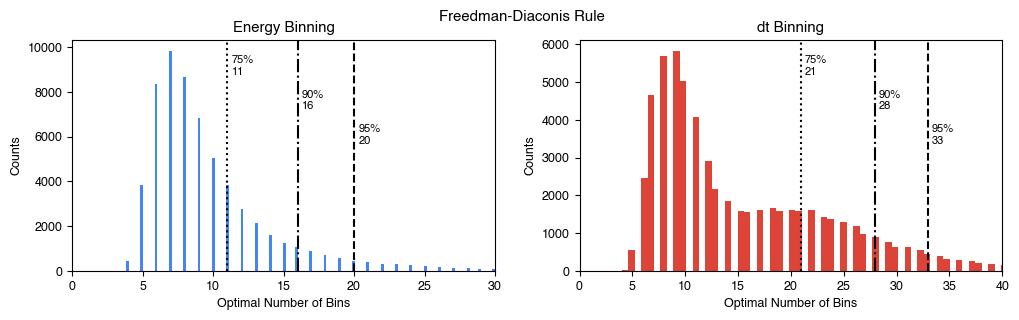

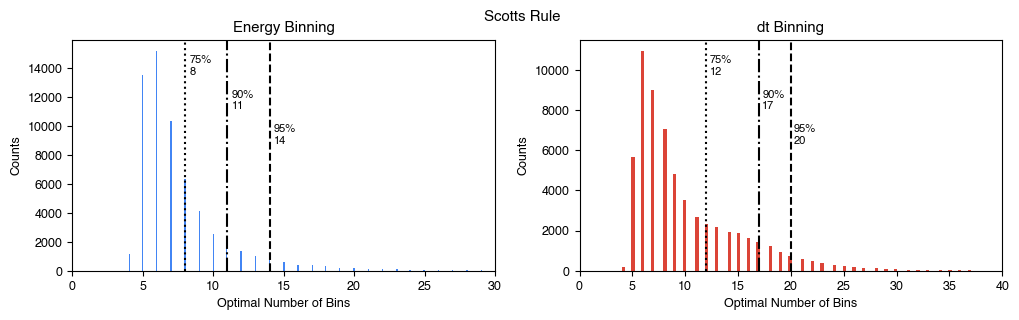

In [10]:
# Set ID
set_id = set_widget.value

Edt_binning_plotter(nbin_E_list,nbin_dt_list,binning_rule = 'Freedman-Diaconis Rule',xlim_E = [0,30],xlim_dt = [0,40],nbins_E=150,nbins_dt=5000)
Edt_binning_plotter(scotts_E_list,scotts_dt_list,binning_rule = 'Scotts Rule',xlim_E = [0,30],xlim_dt = [0,40])

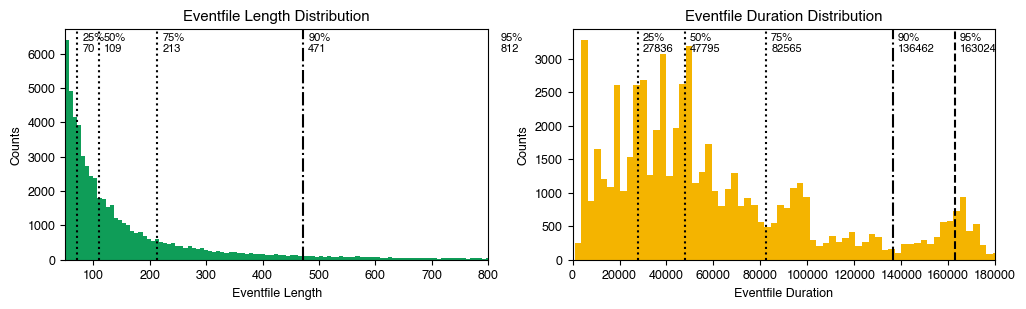

In [12]:
t_binning_plotter(N_list, T_list,xlim_N = [50,800],xlim_T = [0,180000])


In [ ]:
perc10_N = np.percentile(N_list, 10)
print(perc10_N)

Show

Number of Eventfiles:  60995

 Freedman-Diaconis Rule, depends on length of an eventfile and IQR
Min. nE (Freedman-Diaconis): 3
Min. ndt (Freedman-Diaconis):  4
Min. nt (Freedman-Diaconis):  2
Max. nE (Freedman-Diaconis): 169
Max. ndt (Freedman-Diaconis):  153
Max. nt (Freedman-Diaconis):  2358
Avg. nE (Freedman-Diaconis): 10
Avg. ndt (Freedman-Diaconis):  16
Avg. nt (Freedman-Diaconis):  7
Med. nE (Freedman-Diaconis): 8
Med. ndt (Freedman-Diaconis):  12
Med. nt (Freedman-Diaconis):  6
Mode nE (Freedman-Diaconis): 7
Mode ndt (Freedman-Diaconis):  9
Mode nt (Freedman-Diaconis):  5
95percentile nE (Freedman-Diaconis):  20.0
95percentile ndt (Freedman-Diaconis):  33.0
95percentile nt (Freedman-Diaconis):  11.0
90percentile nE (Freedman-Diaconis):  16.0
90percentile ndt (Freedman-Diaconis):  28.0
90percentile nt (Freedman-Diaconis):  9.0
80percentile nE (Freedman-Diaconis):  12.0
80percentile ndt (Freedman-Diaconis):  23.0
80percentile nt (Freedman-Diaconis):  7.0
75percentile nE (Freedman

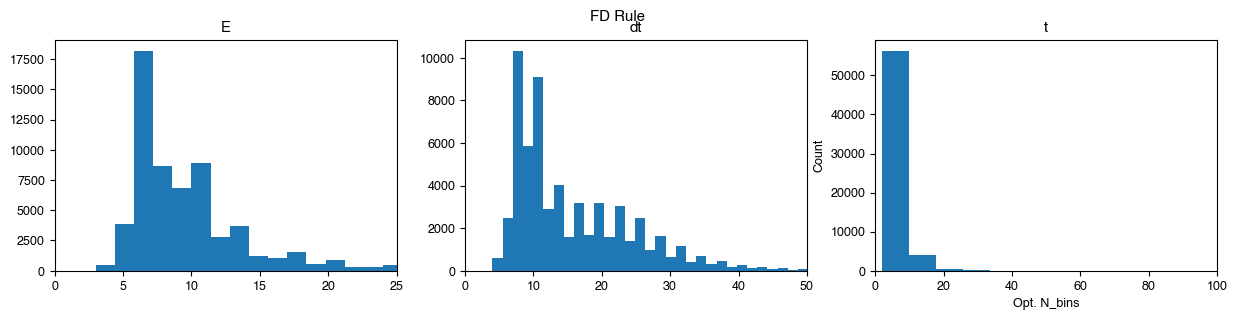

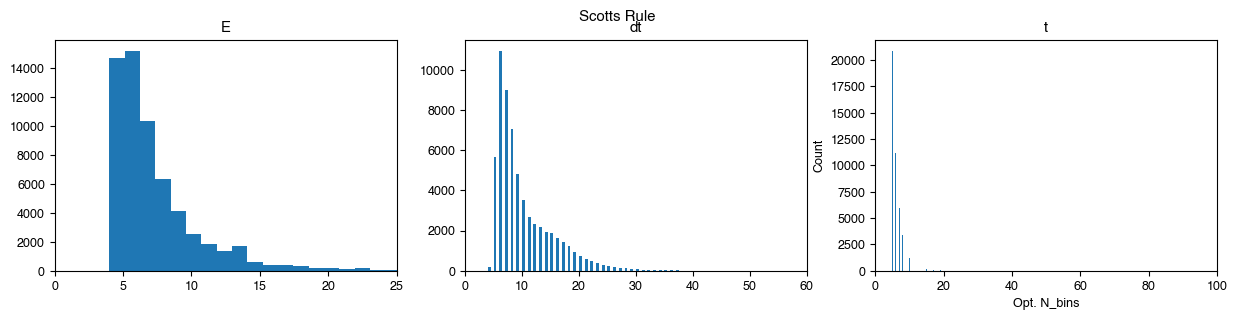

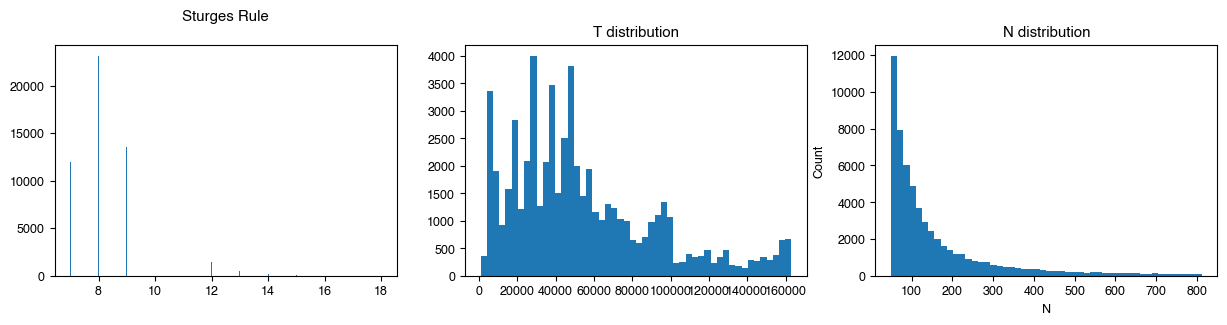

In [14]:
# See Overleaf for advantages and disadvantages etc.
# Thoughts: Best method is the Freedman-Diaconis (FD) rule, but can check bounds of Sturges and Scotts to see if our result with FD falls within that range
# Question is now: Do we use the MAX or AVG for the number of bins (look at distributions!), AVG may not represent the data well in some cases (hides variability), 
# but Max values may be a few single outliers...LOOK AT DISTRIBUTIONS
print("Number of Eventfiles: ", len(sturges_list))

# FD
print('\n Freedman-Diaconis Rule, depends on length of an eventfile and IQR')
print('Min. nE (Freedman-Diaconis):', min(nbin_E_list))
print('Min. ndt (Freedman-Diaconis): ', min(nbin_dt_list))
print('Min. nt (Freedman-Diaconis): ', min(nbin_t_list))
print('Max. nE (Freedman-Diaconis):', max(nbin_E_list))
print('Max. ndt (Freedman-Diaconis): ', max(nbin_dt_list))
print('Max. nt (Freedman-Diaconis): ', max(nbin_t_list))
print('Avg. nE (Freedman-Diaconis):', int(np.ceil(sum(nbin_E_list)/len(nbin_E_list))))
print('Avg. ndt (Freedman-Diaconis): ', int(np.ceil(sum(nbin_dt_list)/len(nbin_dt_list))))
print('Avg. nt (Freedman-Diaconis): ', int(np.ceil(sum(nbin_t_list)/len(nbin_t_list))))
print('Med. nE (Freedman-Diaconis):', statistics.median(nbin_E_list))
print('Med. ndt (Freedman-Diaconis): ', statistics.median(nbin_dt_list))
print('Med. nt (Freedman-Diaconis): ', statistics.median(nbin_t_list))
print('Mode nE (Freedman-Diaconis):', statistics.mode(nbin_E_list))
print('Mode ndt (Freedman-Diaconis): ', statistics.mode(nbin_dt_list))
print('Mode nt (Freedman-Diaconis): ', statistics.mode(nbin_t_list))
print('95percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 95))
print('95percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 95))
print('95percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 95))
print('90percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 90))
print('90percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 90))
print('90percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 90))
print('80percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 80))
print('80percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 80))
print('80percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 80))
print('75percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 75))
print('75percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 75))
print('75percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 75))
print('50percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 50))
print('50percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 50))
print('50percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 50))

print('95percentile T: ', np.percentile(T_list, 95))
print('90percentile T: ', np.percentile(T_list, 90))
print('80percentile T: ', np.percentile(T_list, 80))
print('75percentile T: ', np.percentile(T_list, 75))
print('50percentile T: ', np.percentile(T_list, 50))

print('99.9percentile N: ', np.percentile(N_list, 99.9))
print('99percentile N: ', np.percentile(N_list, 99))
print('98percentile N: ', np.percentile(N_list, 98))
print('97percentile N: ', np.percentile(N_list, 97))
print('96percentile N: ', np.percentile(N_list, 96))
print('95percentile N: ', np.percentile(N_list, 95))
print('90percentile N: ', np.percentile(N_list, 90))
print('80percentile N: ', np.percentile(N_list, 80))
print('75percentile N: ', np.percentile(N_list, 75))
print('50percentile N: ', np.percentile(N_list, 50))

print('Min Scaled dt: ', min(scaled_dt_list))
print('Max Scaled dt: ', max(scaled_dt_list))
print('Min No Scaled dt: ', min(no_scaled_dt_list))
print('Max No Scaled dt: ', max(no_scaled_dt_list))


# Scotts
print('\n Scotts Rule, depends on length of an eventfile and standard deviation')
print('Min. nE (Scotts): ', min(scotts_E_list))
print('Min. ndt (Scotts): ', min(scotts_dt_list))
print('Min. nt (Scotts): ', min(scotts_t_list))
print('Max. nE (Scotts): ', max(scotts_E_list))
print('Max. ndt (Scotts): ', max(scotts_dt_list))
print('Max. nt (Scotts): ', max(scotts_t_list))
print('Avg. nE (Scotts): ', int(np.ceil(sum(scotts_E_list)/len(scotts_E_list))))
print('Avg. ndt (Scotts): ', int(np.ceil(sum(scotts_dt_list)/len(scotts_dt_list))))
print('Avg. nt (Scotts): ', int(np.ceil(sum(scotts_t_list)/len(scotts_t_list))))
print('Med. nE (Scotts): ', statistics.median(scotts_E_list))
print('Med. ndt (Scotts): ', statistics.median(scotts_dt_list))
print('Med. nt (Scotts): ', statistics.median(scotts_t_list))
print('95percentile nE (Scotts): ', np.percentile(scotts_E_list, 95))
print('95percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 95))
print('95percentile nt (Scotts): ', np.percentile(scotts_t_list, 95))
print('90percentile nE (Scotts): ', np.percentile(scotts_E_list, 90))
print('90percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 90))
print('90percentile nt (Scotts): ', np.percentile(scotts_t_list, 90))
print('80percentile nE (Scotts): ', np.percentile(scotts_E_list, 80))
print('80percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 80))
print('80percentile nt (Scotts): ', np.percentile(scotts_t_list, 80))
print('75percentile nE (Scotts): ', np.percentile(scotts_E_list, 75))
print('75percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 75))
print('75percentile nt (Scotts): ', np.percentile(scotts_t_list, 75))

# Sturges
print('\n Sturges Rule, only dependents on length of an eventfile (hence same nbins for E and dt), assumes normal distribution of data')
print('Min. n (Sturges):', min(sturges_list)) # Assumes normal distr tho
print('Max. n (Sturges):', max(sturges_list)) # Assumes normal distr tho
print('Avg. n (Sturges):', int(np.ceil(sum(sturges_list)/len(sturges_list)))) # Assumes normal distr tho
print('Med. n (Sturges):', statistics.median(sturges_list)) # Assumes normal distr tho
print('95percentile n (Sturges): ', np.percentile(sturges_list, 95))
print('90percentile n (Sturges): ', np.percentile(sturges_list, 90))
print('75percentile n (Sturges): ', np.percentile(sturges_list, 75))

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Can also plot them on top of each other for comparison!!!

# IDEA: get only 2-3std away from mean and plot distributions again

# FD Rule
percentile_99 = np.percentile(nbin_E_list, 99)

filtered_list = [x for x in nbin_E_list if x <= percentile_99]


fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(15, 3))
fig.suptitle('FD Rule\n')
#ax1.hist(nbin_E_list,bins=100)
ax1.hist(filtered_list,bins=20)
ax1.set_title('E')
ax1.set_xlim([0,25])
#ax1.set_xlim([np.percentile(nbin_E_list,0), np.percentile(nbin_E_list,99)])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(nbin_dt_list,bins=100)
ax2.set_title('dt')
ax2.set_xlim([0,50])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax3.hist(nbin_t_list,bins=300)
ax3.set_title('t')
ax3.set_xlim([0,100])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')

# Scotts Rule
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(15, 3))
fig.suptitle('Scotts Rule')
ax1.hist(scotts_E_list,bins=100)
ax1.set_title("E")
ax1.set_xlim([0,25])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(scotts_dt_list,bins=100)
ax2.set_title("dt")
ax2.set_xlim([0,60])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax3.hist(scotts_t_list,bins=300)
ax3.set_title("t")
ax3.set_xlim([0,100])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')

percentile_95_T = np.percentile(T_list, 95)
percentile_95_N = np.percentile(N_list, 95)

filtered_list_T = [x for x in T_list if x <= percentile_95_T]
filtered_list_N = [x for x in N_list if x <= percentile_95_N]

# Sturges
fig2, (ax1, ax2,ax3)  = plt.subplots(1, 3,figsize=(15, 3))
ax1.hist(sturges_list,bins=500)
ax1.set_title('Sturges Rule\n')
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(filtered_list_T,bins=50)
ax2.set_title('T distribution')
plt.xlabel('T')
plt.ylabel('Count')
ax3.hist(filtered_list_N,bins=50)
ax3.set_title('N distribution')
plt.xlabel('N')
plt.ylabel('Count')



plt.show()

#Fails 
#print("Fails: ", id_fail)

In [ ]:
print(T_list)